# Оптимизация маркетинговых затрат в Яндекс.Афише

## Описание задачи

Помочь маркетологам оптимизировать маркетинговые затраты.
Для этого изучим:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## План выполнения работы

- Шаг 1. Загрузка данных и подготовка их к анализу
- Шаг 2. Построение отчётов и подсчет метрик
- Шаг 3. Выводы и рекомендации

## Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ознакомимся с данными
visits = pd.read_csv('/datasets/visits_log.csv')
visits

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
costs = pd.read_csv('/datasets/costs.csv')
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [8]:
# Приведем нижнему регистру и добавим нижнее подчеркивание вместо пробела в названиях столбцов датасетов 
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
visits = visits.rename(columns={'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts'})
orders = orders.rename(columns={'buy ts':'buy_ts'})
costs = costs.rename(columns={'dt':'date_costs'})
visits, orders

(         device               end_ts  source_id             start_ts  \
 0         touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
 1       desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
 2         touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
 3       desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
 4       desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   
 ...         ...                  ...        ...                  ...   
 359395  desktop  2017-07-29 19:07:19          2  2017-07-29 19:07:00   
 359396    touch  2018-01-25 17:38:19          1  2018-01-25 17:38:00   
 359397  desktop  2018-03-03 10:12:19          4  2018-03-03 10:12:00   
 359398  desktop  2017-11-02 10:12:19          5  2017-11-02 10:12:00   
 359399    touch  2017-09-10 13:13:19          2  2017-09-10 13:13:00   
 
                          uid  
 0       16879256277535980062  
 1         104060357244891740  
 2        7459035603376831

In [9]:
# Приведем столбцы даты к формату datatime
visits[['end_ts', 'start_ts']] = visits[['end_ts', 'start_ts']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
orders['buy_ts'] = orders['buy_ts'].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
costs['date_costs'] = costs['date_costs'].apply(pd.to_datetime, format='%Y-%m-%d')
costs.info(), orders.info(), visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id     2542 non-null int64
date_costs    2542 non-null datetime64[ns]
costs         2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


(None, None, None)

### Промежуточные выводы

Размеры датасетов:
- visits: 359400 строк 5 столбцов;
- orders: 50415 строк, 3 столбца;
- costs: 2542 строк, 3 столбца.

В таблицах visits и orders название столбцов были приведены к нижнему регистру, а пробелы заменены на нижнее подчеркивание. Также во всех таблицах столбцы даты были приведены к формату datetime.

## Шаг 2. Построение отчётов и подсчет метрик

###  Сколько людей пользуются в день, неделю, месяц? DAU, WAU и MAU

In [10]:
# Выделим день, неделю, месяц и год из даты начала сессии
visits['day_start_ts'] = pd.DatetimeIndex(visits['start_ts']).date
visits['week_start_ts'] = pd.DatetimeIndex(visits['start_ts']).week
visits['month_start_ts'] = pd.DatetimeIndex(visits['start_ts']).month
visits['year_start_ts'] = pd.DatetimeIndex(visits['start_ts']).year
visits

,device,end_ts,source_id,start_ts,uid,day_start_ts,week_start_ts,month_start_ts,year_start_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,30,7,2017
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,4,1,2018
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,9,3,2018
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,44,11,2017


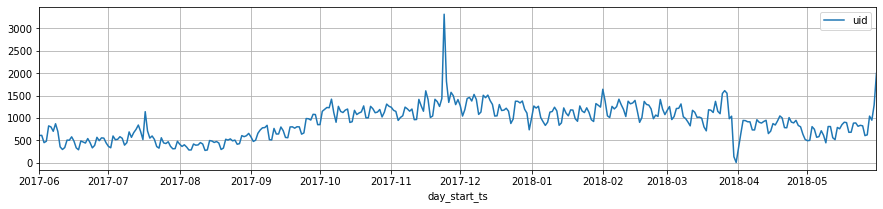

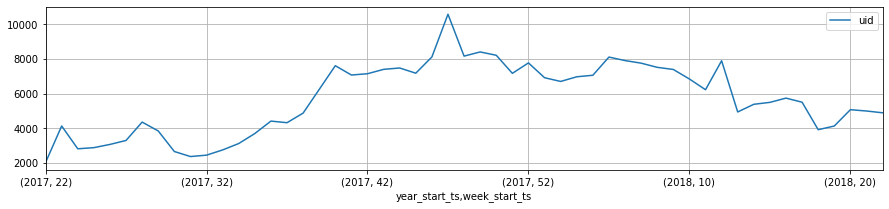

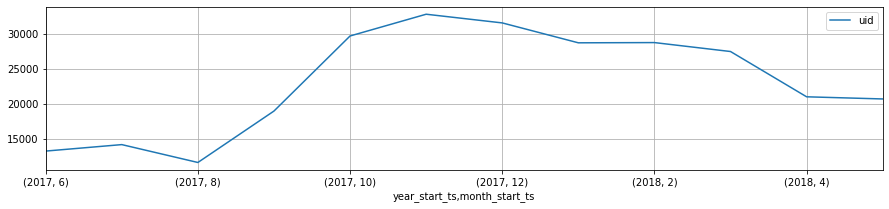

In [11]:
# Найдем метрики DAU, WAU и MAU
dau_total = visits.groupby('day_start_ts').agg({'uid':'nunique'})
wau_total = visits.groupby(['year_start_ts','week_start_ts']).agg({'uid':'nunique'})
mau_total = visits.groupby(['year_start_ts','month_start_ts']).agg({'uid':'nunique'})
# Построим графики
dau_total.plot(grid=True, figsize=(15, 3))
wau_total.plot(grid=True, figsize=(15, 3))
mau_total.plot(grid=True, figsize=(15, 3))
plt.show()

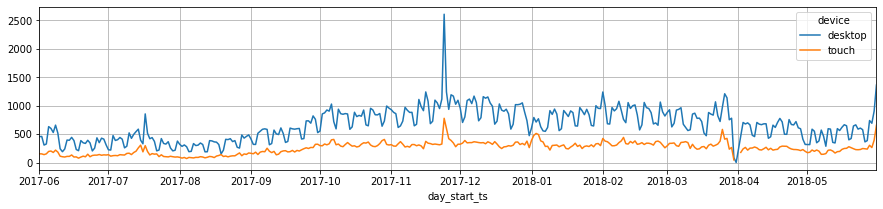

In [12]:
# Найдем метрики DAU, WAU и MAU в разбивке по типу устройства
# DAU
dau_device = (visits.groupby(['device','day_start_ts'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                    .pivot_table(index='day_start_ts', columns='device', values='uid')
              )
dau_device.plot(grid=True, figsize=(15, 3))
plt.show()

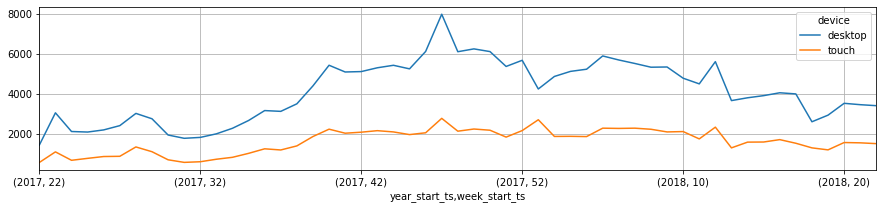

In [13]:
# WAU
wau_device = (visits.groupby(['device', 'year_start_ts','week_start_ts'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                    .pivot_table(index=['year_start_ts','week_start_ts'], columns='device', values='uid')
              )
wau_device.plot(grid=True, figsize=(15, 3))
plt.show()

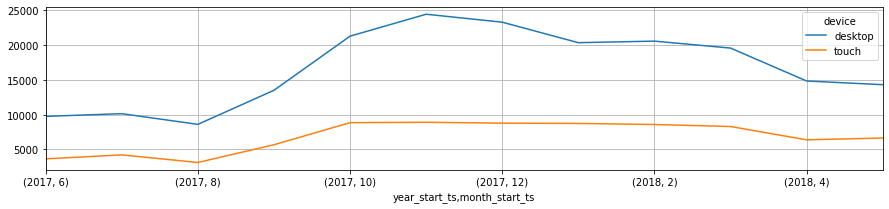

In [14]:
# MAU
mau_device = (visits.groupby(['device', 'year_start_ts','month_start_ts'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                    .pivot_table(index=['year_start_ts','month_start_ts'], columns='device', values='uid')
              )
mau_device.plot(grid=True, figsize=(15, 3))
plt.show()

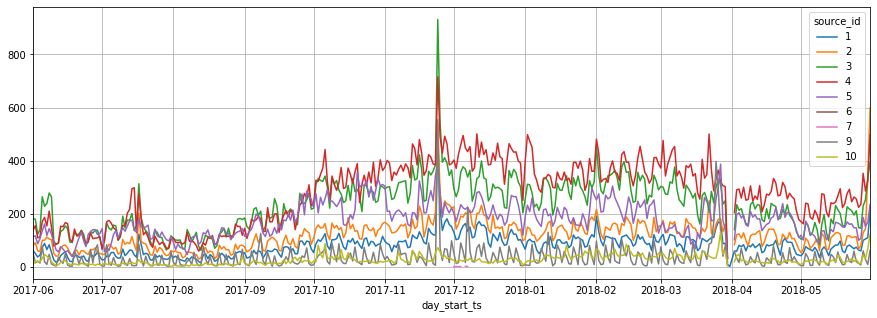

In [15]:
# Найдем метрики DAU, WAU и MAU в разбивке по рекламным источникам
# DAU
dau_device = (visits.groupby(['source_id','day_start_ts'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                    .pivot_table(index='day_start_ts', columns='source_id', values='uid')
              )
dau_device.plot(grid=True, figsize=(15, 5))
plt.show()

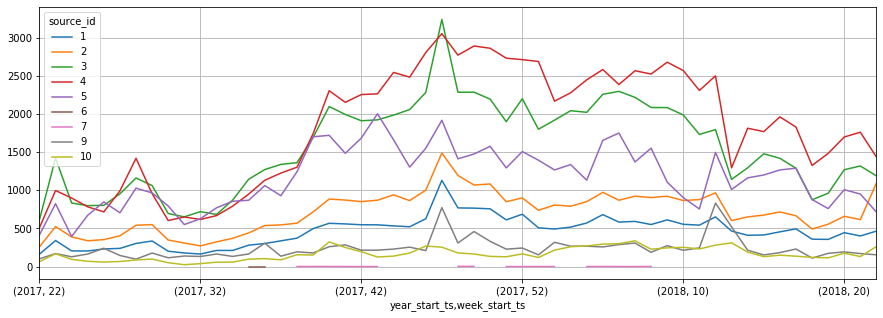

In [16]:
# WAU
wau_device = (visits.groupby(['source_id', 'year_start_ts','week_start_ts'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                    .pivot_table(index=['year_start_ts','week_start_ts'], columns='source_id', values='uid')
              )
wau_device.plot(grid=True, figsize=(15, 5))
plt.show()

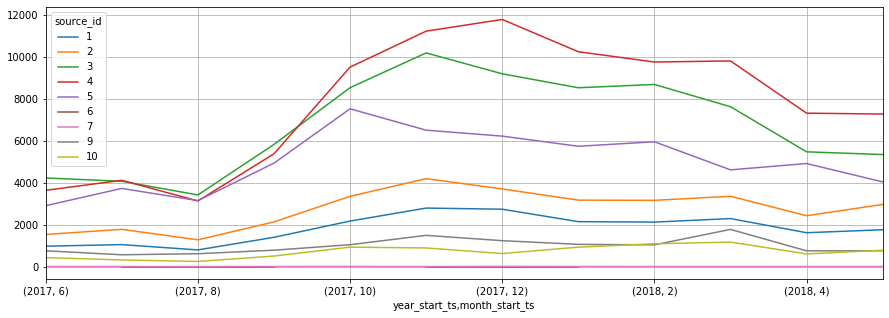

In [17]:
# MAU
mau_device = (visits.groupby(['source_id', 'year_start_ts','month_start_ts'])
                    .agg({'uid':'nunique'})
                    .reset_index()
                    .pivot_table(index=['year_start_ts','month_start_ts'], columns='source_id', values='uid')
              )
mau_device.plot(grid=True, figsize=(15, 5))
plt.show()

### Промежуточные выводы
Кол-во новых пользователей повышается ближе к Новому году. Непосредственно с Новым годом виден сильный пик по приросту новых пользователей, после это падение примерно на прежний уровень. В разрезе устройст ситуация похожа, причем прирост графики у desktop и touch идут параллельно, разве что у desktop в целом аудитория больше. Что касается графиков новых пользователей по рекламным источникам, то по привлечению новых пользователей выделяются источники 3, 4 и 5. Также на всех графиках наблюдается провал в районе августа.

### Сколько сессий в день?

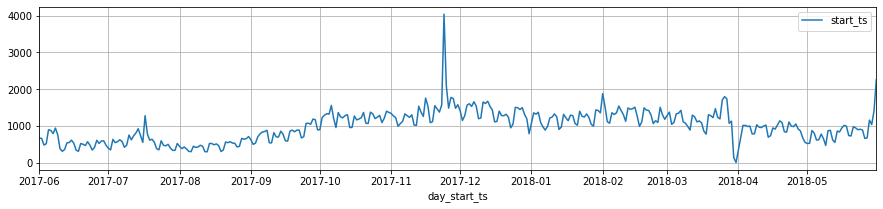

In [18]:
# Посчитаем кол-во сессий в день
visits_per_day = visits.groupby('day_start_ts').agg({'start_ts':'count'})
visits_per_day.plot(grid=True, figsize=(15, 3))
plt.show()

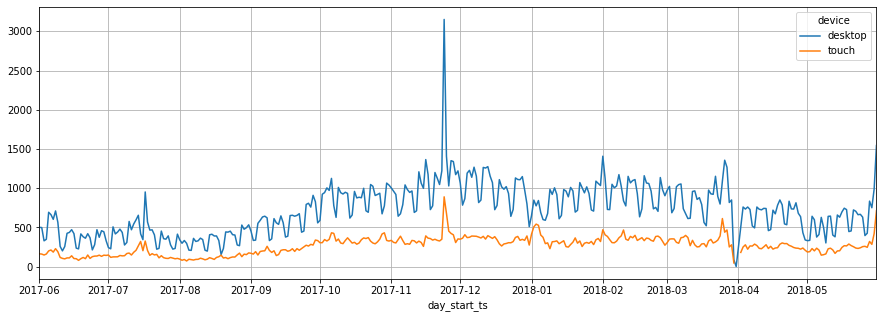

In [19]:
# Посчитаем кол-во сессий в день по устройствам
visits_per_day_device = (visits.groupby(['device','day_start_ts'])
                       .agg({'start_ts':'count'})
                       .reset_index()
                       .pivot_table(index='day_start_ts', columns='device', values='start_ts')
                 )
visits_per_day_device.plot(grid=True, figsize=(15, 5))
plt.show()

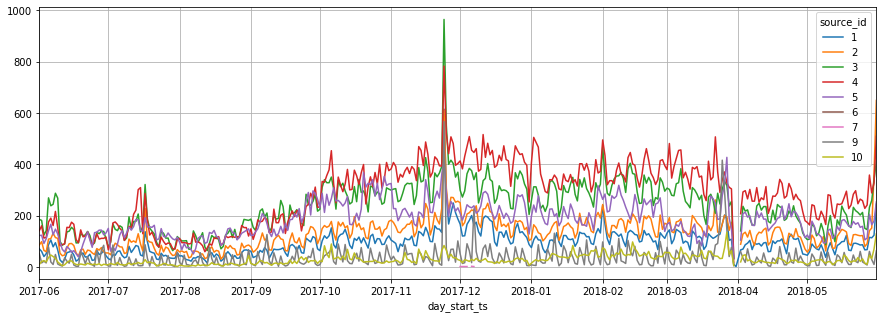

In [20]:
# Посчитаем кол-во сессий в день по рекламным источникам
visits_per_day_source_id = (visits.groupby(['source_id','day_start_ts'])
                       .agg({'start_ts':'count'})
                       .reset_index()
                       .pivot_table(index='day_start_ts', columns='source_id', values='start_ts')
                 )
visits_per_day_source_id.plot(grid=True, figsize=(15, 5))
plt.show()

### Промежуточные выводы

В целом графики коррелируют с предыдущей метрикой.

### Сколько длится одна сессия?

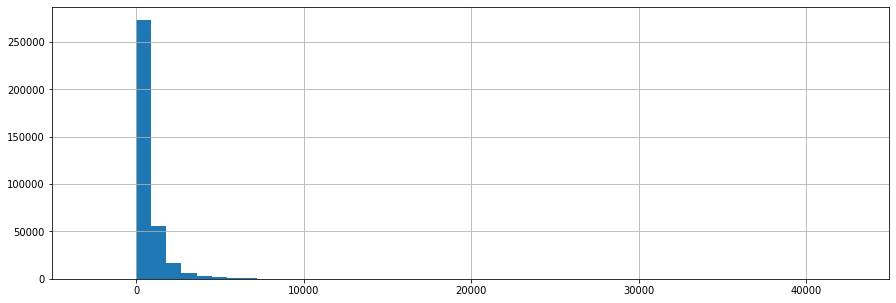

In [21]:
# Посчитаем сколько длится одна сессия в секундах
visits['duration_ts'] = (visits['end_ts'] - visits['start_ts']) / np.timedelta64(1,'s')
visits['duration_ts'].hist(bins=50, figsize=(15, 5))
plt.show()


In [22]:
visits['duration_ts'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: duration_ts, dtype: float64

In [23]:
visits['duration_ts'].mode()

0    60.0
dtype: float64

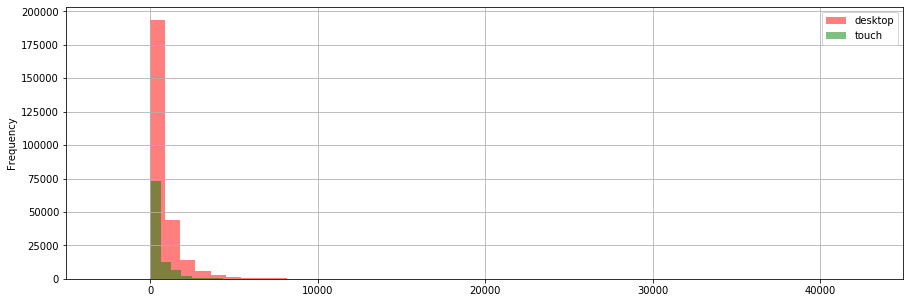

In [24]:
# Посчитаем сколько длится одна сессия в секундах и построим графики для каждого устройства
ax = (visits.loc[visits['device'] == 'desktop', 'duration_ts']
      .plot(kind='hist', bins=50, label='desktop', color='r', legend=True, grid=True, alpha=0.5, figsize=(15, 5)))
(visits.loc[visits['device'] == 'touch', 'duration_ts']
.plot(kind='hist', bins=50, label='touch', color='g', grid=True, legend=True, alpha=0.5, ax=ax))
plt.show()

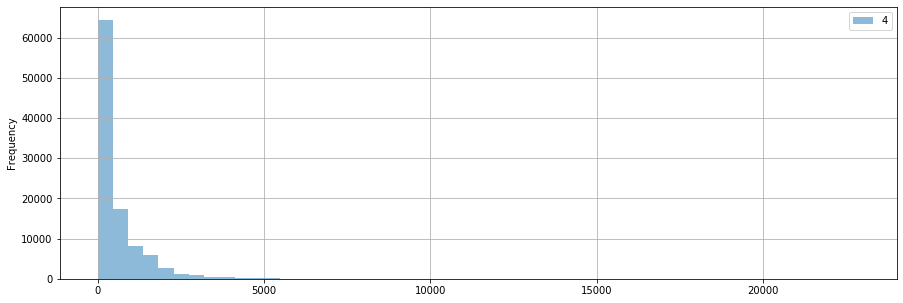

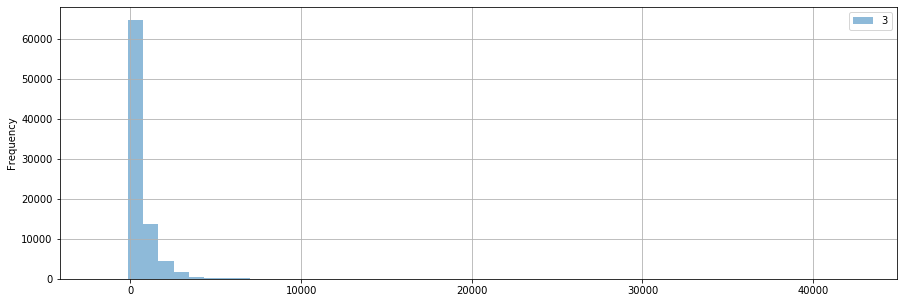

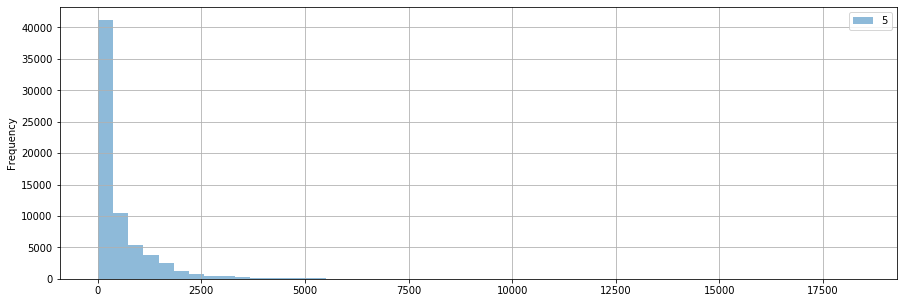

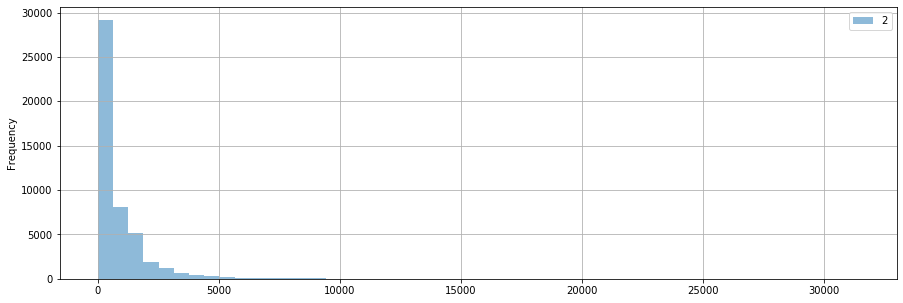

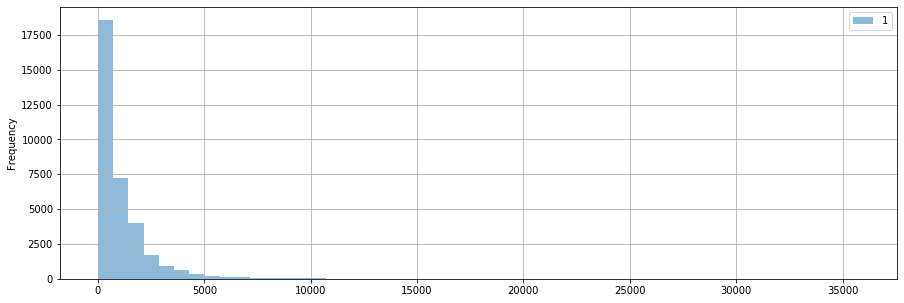

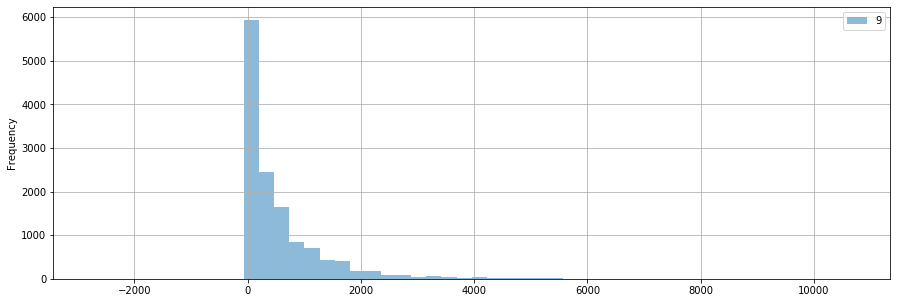

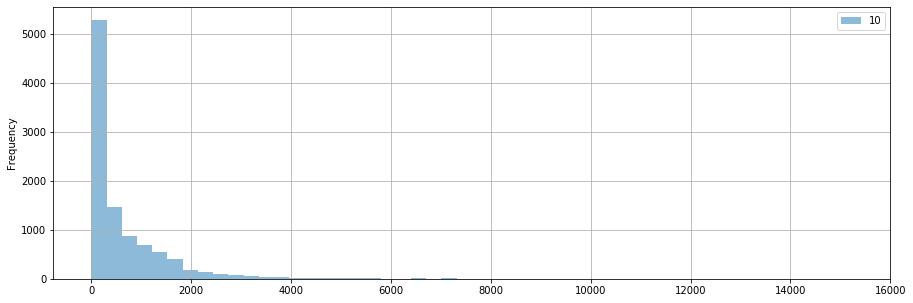

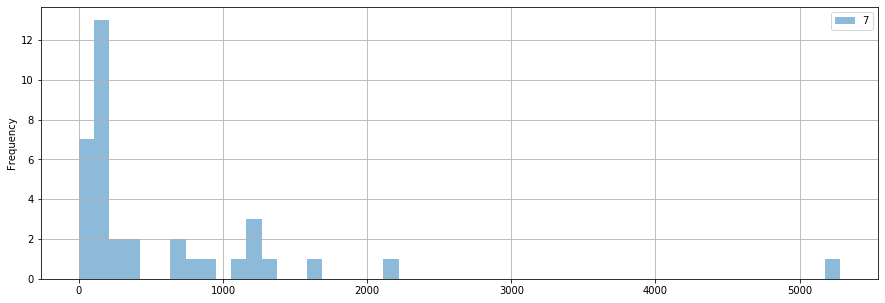

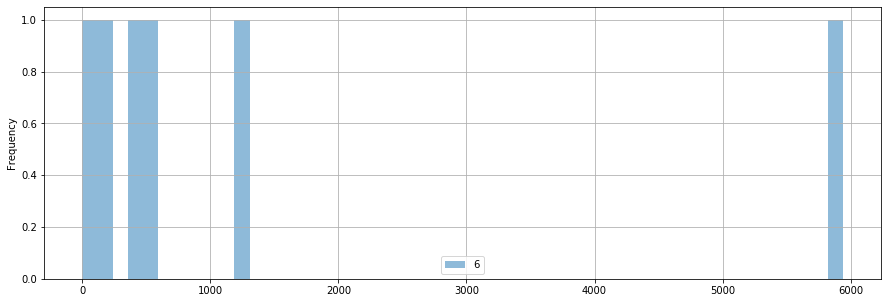

In [25]:
# Посчитаем сколько длится одна сессия в секундах и построим графики для каждого рекламного источника
for i in visits.source_id.value_counts().index:
    (visits.loc[visits['source_id'] == i, 'duration_ts']
     .plot(kind='hist', bins=50, label=i, grid=True, legend=True, alpha=0.5, figsize=(15, 5)))
    plt.show()

In [26]:
# Отметим, что в данных существует ошибка - дата окончания сессии раньше, чем дата начала сессии
visits[visits['duration_ts'] < 0]

,device,end_ts,source_id,start_ts,uid,day_start_ts,week_start_ts,month_start_ts,year_start_ts,duration_ts
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-25,12,3,2018,-1920.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-25,12,3,2018,-2760.0


### Промежуточные выводы

Средняя сессия пользователя длится 643 секунды или около 10,5 минут. Самое распространенное значение составляет 60 секунд. Распределение по устройствам и рекламным источникам аналогичное. Отметим ошибки в данных у двух сессий, где время ее начала позже, чем время ее конца.

### Как часто люди возвращаются? Retention rate

In [27]:
# Для подсчета retention rate разобьем пользователей на когорты по месяцу начала их первой сессии
first_activity_day = visits.groupby(['uid'])['day_start_ts'].min()
first_activity_day.name = 'first_activity_day'
visits = visits.join(first_activity_day, on='uid')

In [28]:
visits['first_activity_month'] = visits['first_activity_day'].astype('datetime64[M]')
visits['ts_month'] = visits['start_ts'].astype('datetime64[M]')
# Выделим lifetime
visits['cohort_lifetime'] = (((visits['ts_month']- visits['first_activity_month']) / np.timedelta64(1,'M'))
                                                .round() 
                                                .astype('int'))
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_uid_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_uid_count = initial_uid_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_uid_count,on='first_activity_month')
# Посчитаем retention rate
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot.loc[:, '1':'9']

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,
2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


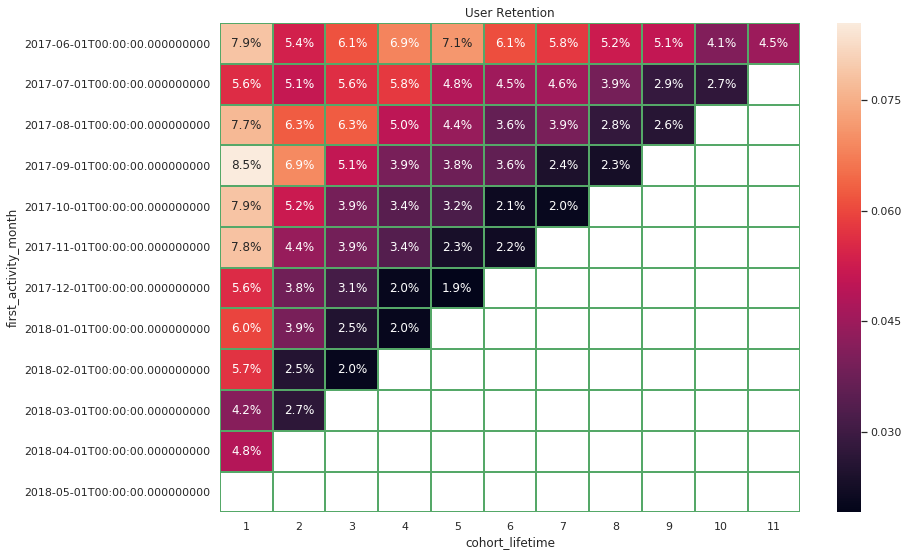

In [29]:
# Создадим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('User Retention')
sns.heatmap(retention_pivot.loc[:, '1':'9'], annot=True, fmt='.1%', linewidths=1, linecolor='g');

In [30]:
# Разобьем на когорты по устройствам и посчитаем retention rate
# Горизонтом окупаемости выберем 6 месяцев
cohorts_devices = (visits[visits['month_start_ts'] >= 6]
                                                       .groupby(['device', 'cohort_lifetime'])
                                                       .agg({'uid':'nunique'}).reset_index())
initial_users_count1 = cohorts_devices[cohorts_devices['cohort_lifetime'] == 0][['device','uid']]
initial_users_count1 = initial_users_count1.rename(columns={'uid':'cohort_users'})
cohorts_devices = cohorts_devices.merge(initial_users_count1, on='device')
cohorts_devices['retention'] = cohorts_devices['uid'] / cohorts_devices['cohort_users']
retention_pivot_devices = cohorts_devices.pivot_table(index='device',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot_devices.loc[:, '1':'9']

cohort_lifetime,1,2,3,4,5,6
device,,,,,,
desktop,0.064936,0.036682,0.025168,0.018357,0.013455,0.006885
touch,0.058543,0.031088,0.019743,0.013662,0.009977,0.005291


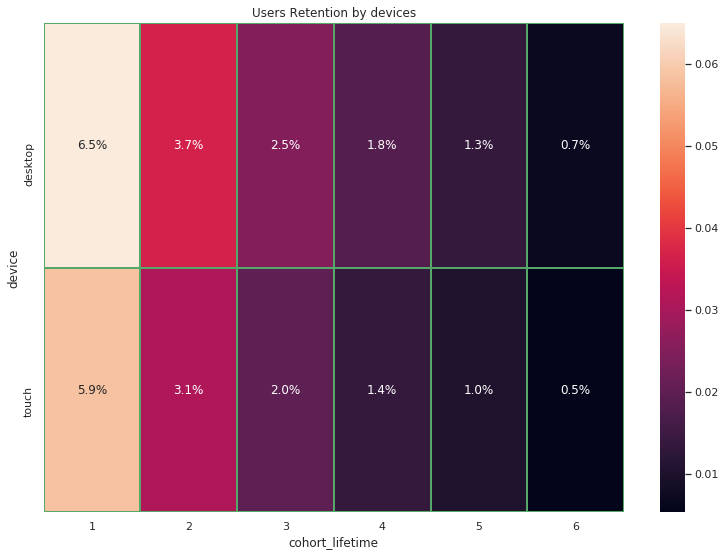

In [31]:
# Создадим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Users Retention by devices')
sns.heatmap(retention_pivot_devices.loc[:, '1':'9'], annot=True, fmt='.1%', linewidths=1, linecolor='g')
plt.show()

In [32]:
# Разобьем на когорты по рекламным источникам и посчитаем retention rate
# Горизонтом окупаемости выберем 6 месяцев
cohorts_source_id = (visits[visits['month_start_ts'] >= 6]
                                                        .groupby(['source_id', 'cohort_lifetime'])
                                                        .agg({'uid':'nunique'})
                                                        .reset_index()
)
initial_users_count2 = cohorts_source_id[cohorts_source_id['cohort_lifetime'] == 0][['source_id','uid']]
initial_users_count2 = initial_users_count2.rename(columns={'uid':'cohort_users'})
cohorts_source_id = cohorts_source_id.merge(initial_users_count2, on='source_id')
cohorts_source_id['retention'] = cohorts_source_id['uid'] / cohorts_source_id['cohort_users']
retention_pivot_source_id = cohorts_source_id.pivot_table(index='source_id',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot_source_id.loc[:, '1':'9']

cohort_lifetime,1,2,3,4,5,6
source_id,,,,,,
1,0.136160,0.066458,0.046207,0.035690,0.030320,0.016894
2,0.162989,0.086302,0.062106,0.047131,0.035624,0.021122
3,0.043664,0.026732,0.020684,0.015279,0.010268,0.005257
4,0.064977,0.037011,0.024363,0.017515,0.013363,0.006896
5,0.043331,0.022531,0.014097,0.009346,0.006923,0.003870
6,0.333333,0.333333,NaN,NaN,NaN,NaN
7,0.045455,NaN,NaN,NaN,NaN,NaN
9,0.150993,0.110155,0.061369,0.050773,0.039294,0.016556
10,0.053137,0.018372,0.013567,0.014415,0.008197,0.001413


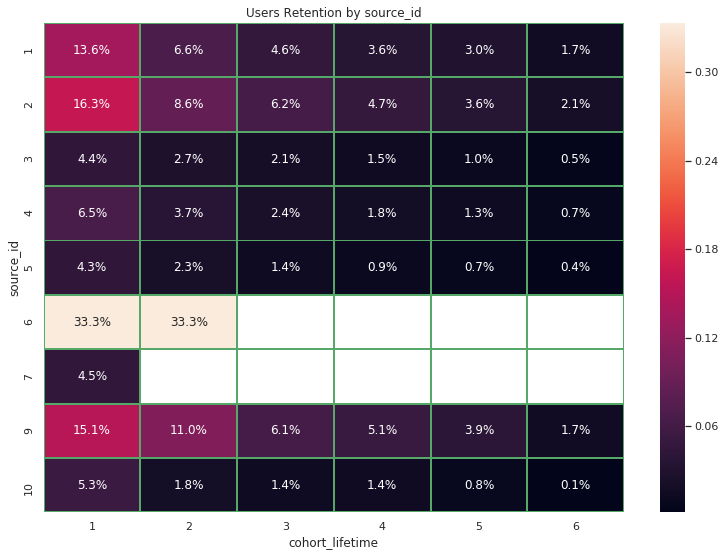

In [33]:
# Создадим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Users Retention by source_id')
sns.heatmap(retention_pivot_source_id.loc[:, '1':'9'], annot=True, fmt='.1%', linewidths=1, linecolor='g')
plt.show()

### Промежуточные выводы

Когортный анализ Retention Rate показал, что процент оставшихся пользователей падает практически до минимума уже за первый месяц (4-8%), аналогичная картина и по устройствам. По рекламным источникам 1, 2 и 9 падение в первый месяц не такое резкое, но значения все равно не большие (13-16%).

### Когда люди начинают покупать?

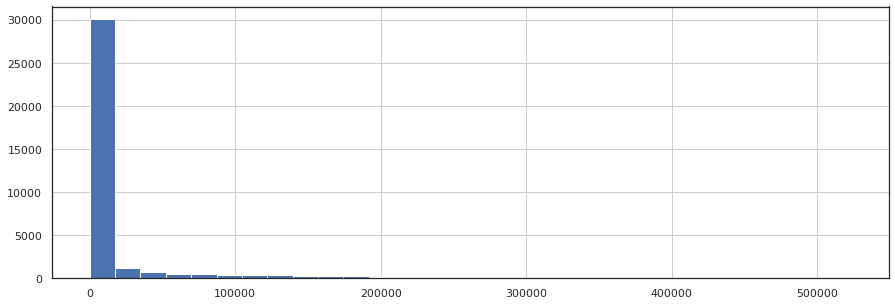

In [34]:
# Найдем дату и время первой сесси клиента, а также дату и время его первго заказа
first_activity = (visits.sort_values(by = ['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
                 )
first_buy = orders.groupby(['uid'])['buy_ts'].min().reset_index()
first_buy_activity = (first_buy.merge(first_activity, on='uid')
                         .rename(columns = {'start_ts':'first_activity', 'buy_ts':'first_buy'}))
first_buy_activity['time_to_buy'] = (((first_buy_activity['first_buy'] - first_buy_activity['first_activity']) / np.timedelta64(1,'m'))
                                                .round() 
                                                .astype('int'))
first_buy_activity['time_to_buy'].hist(bins=30, figsize=(15, 5))
plt.show()

In [35]:
first_buy_activity['time_to_buy'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: time_to_buy, dtype: float64

In [36]:
first_buy_activity['time_to_buy'].value_counts().head(10)

1    2656
0    2455
2    2098
3    1685
4    1460
5    1204
6    1077
7     970
8     793
9     742
Name: time_to_buy, dtype: int64

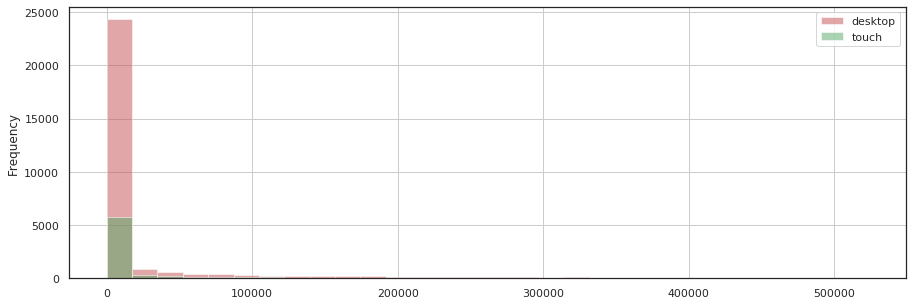

In [37]:
# Найдем дату и время первой сесси клиента, а также дату и время его первго заказа с разбивкой по устройствам
ax = (first_buy_activity.loc[first_buy_activity['device'] == 'desktop', 'time_to_buy']
      .plot(kind='hist', bins=30, label='desktop', color='r', legend=True, grid=True, alpha=0.5, figsize=(15, 5)))
(first_buy_activity.loc[first_buy_activity['device'] == 'touch', 'time_to_buy']
 .plot(kind='hist', bins=30, label='touch', color='g', grid=True, legend=True, alpha=0.5, ax=ax))
plt.show()

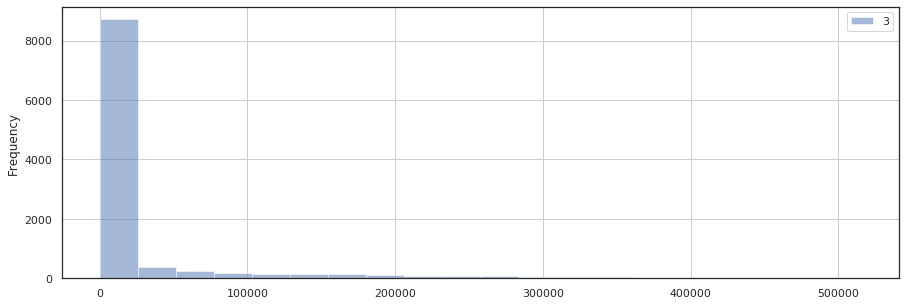

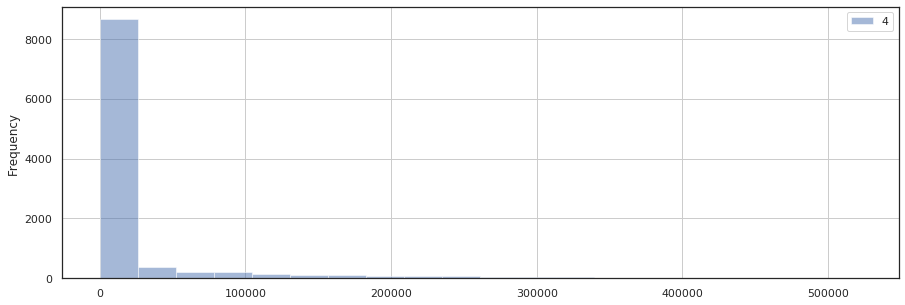

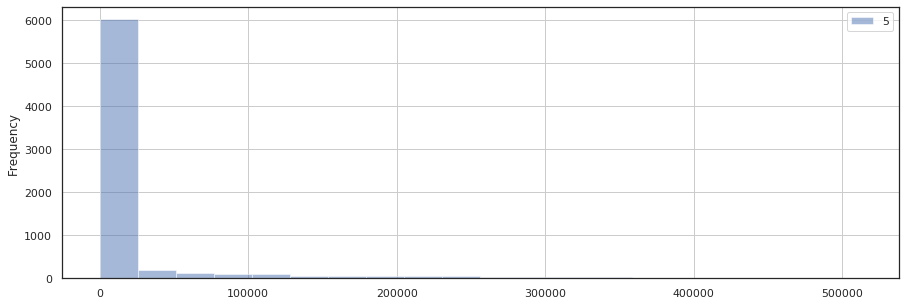

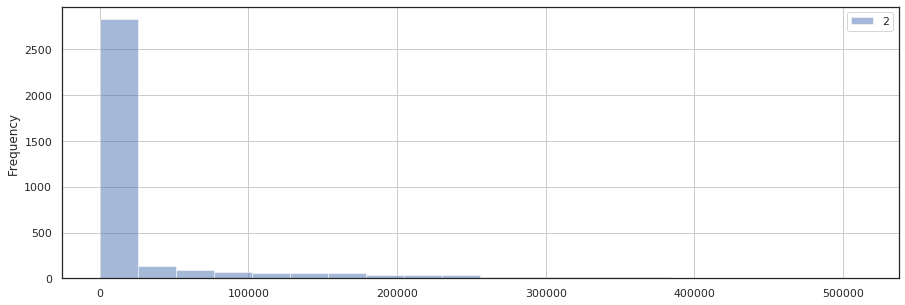

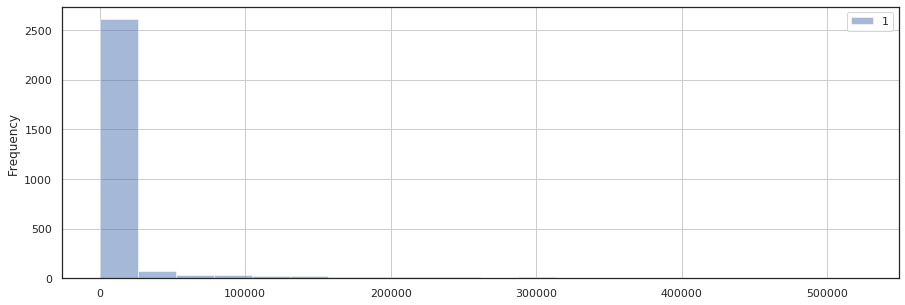

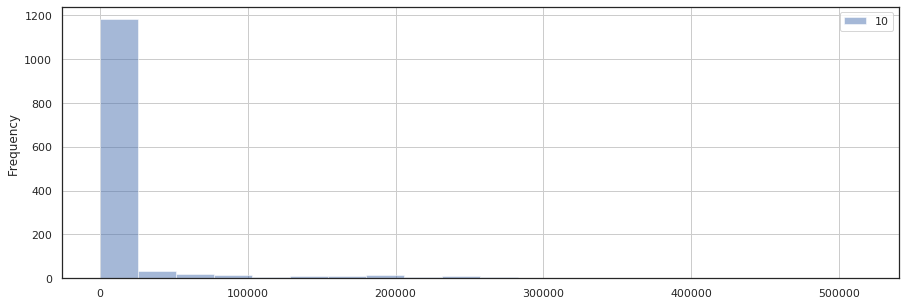

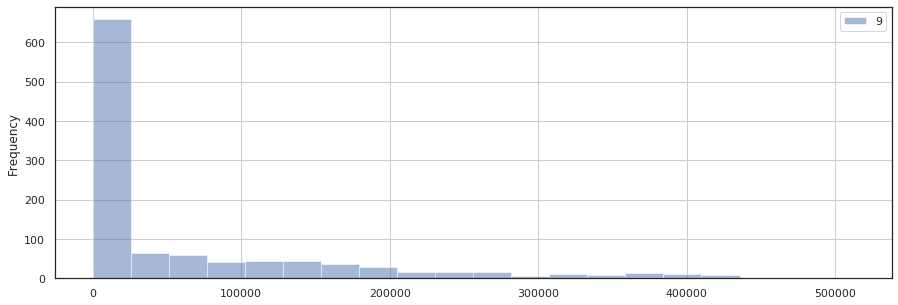

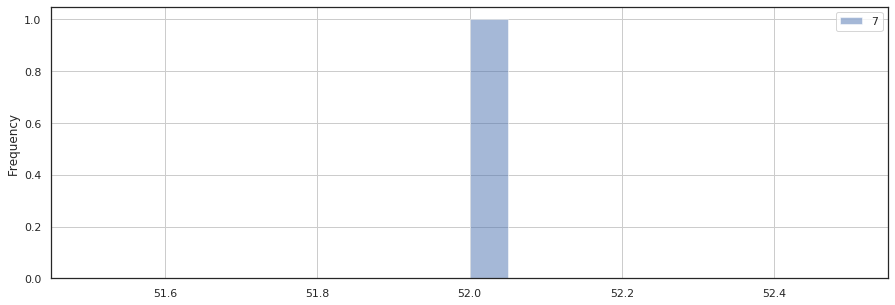

In [38]:
# Найдем дату и время первой сесси клиента, а также дату и время его первго заказа с разбивкой по источникам рекламы
for i in first_buy_activity.source_id.value_counts().index:
    (first_buy_activity.loc[first_buy_activity['source_id'] == i, 'time_to_buy']
     .plot(kind='hist', bins=20, label=i, grid=True, legend=True, alpha=0.5, figsize=(15, 5)))
    plt.show()

### Промежуточные выводы

Чаще все люди покупаю в первые 1-2 минуты.

### Сколько раз покупают за период?

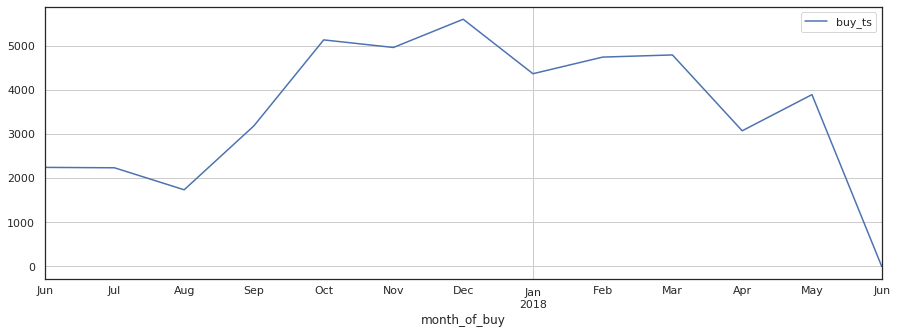

In [39]:
# Выделим месяц и посчитаем кол-во покупок в месяц
orders['month_of_buy'] = orders['buy_ts'].astype('datetime64[M]')
orders.groupby('month_of_buy').agg({'buy_ts':'nunique'}).plot(grid=True, figsize=(15, 5))
plt.show()

In [40]:
# Добавим информацию о device и source_id в таблицу с заказми
visits_sort = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'device':'first', 'source_id':'first'})
visits_orders = orders.merge(visits_sort, on='uid')

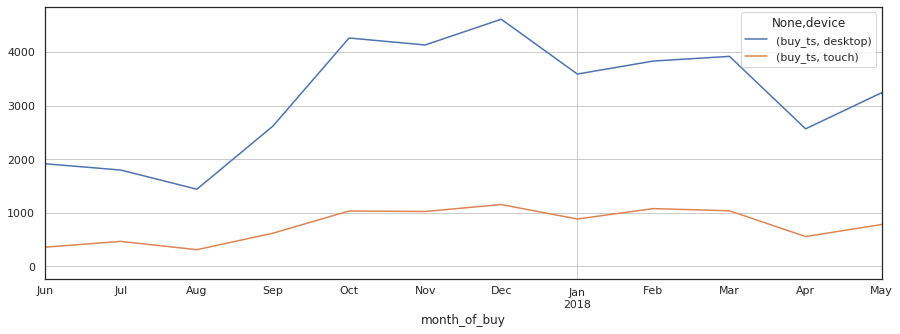

In [41]:
# Выделим месяц и посчитаем кол-во покупок в месяц с разбивкой по устройствам
# Ограничение по графику введем, так как 2018-05-01 только одно значение desktop
(visits_orders.groupby(['device', 'month_of_buy']).agg({'buy_ts':'nunique'})
                                                 .pivot_table(index='month_of_buy', columns='device')
                                                 .plot(grid=True, figsize=(15, 5), xlim=('2017-06-01', '2018-05-01'))
)

plt.show()

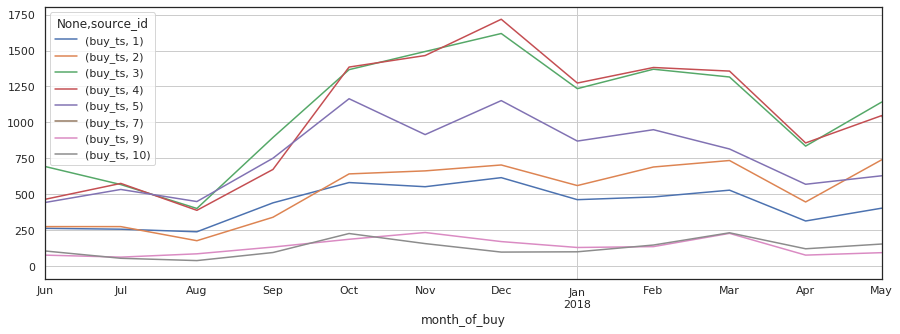

In [42]:
# Выделим месяц и посчитаем кол-во покупок в месяц с разбивкой по рекламному источнику
# Ограничение по графику введем, так как 2018-05-01 только одно значение 4го источника
(visits_orders.groupby(['source_id', 'month_of_buy']).agg({'buy_ts':'nunique'})
                                                 .pivot_table(index='month_of_buy', columns='source_id')
                                                 .plot(grid=True, figsize=(15, 5), xlim=('2017-06-01', '2018-05-01'))
)
plt.show()

### Промежуточные выводы

Кол-во покупок достигает своего пика к Новому году. По устройствам в лидерах desctop, по источникам - источники 3 и 4.

### Какой средний чек?

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

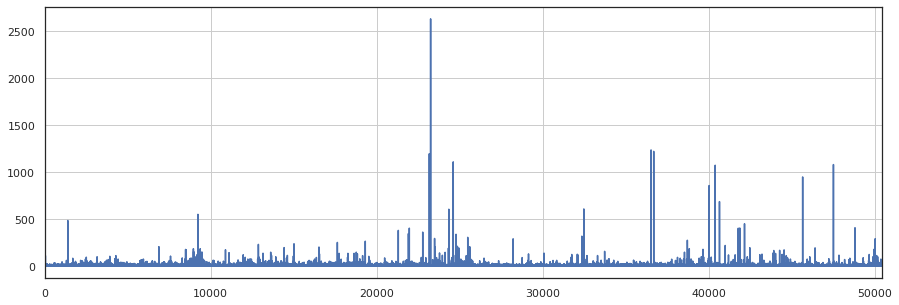

In [43]:
# Определим средний чек
orders.revenue.plot(grid=True, figsize=(15, 5))
#plt.show()
orders.revenue.describe()

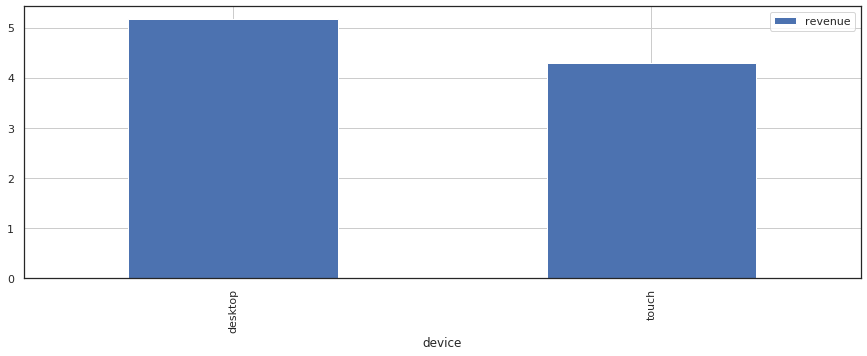

In [44]:
# Определим средний чек по устройствам
visits_orders.pivot_table(index='device', values='revenue').plot(kind='bar', grid=True, figsize=(15, 5))
plt.show()

In [45]:
visits_orders.pivot_table(index='device', values='revenue')

,revenue
device,
desktop,5.163578
touch,4.292520


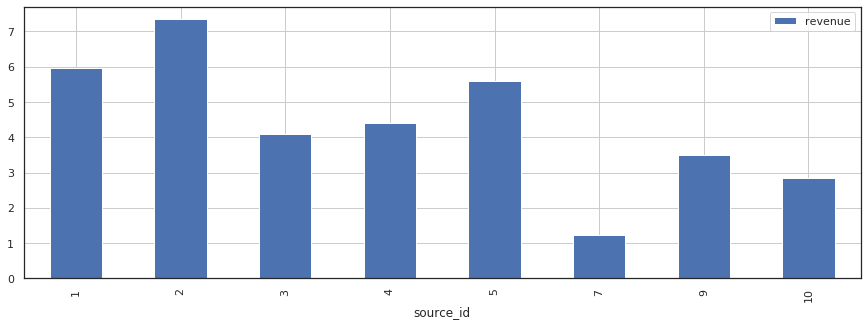

In [46]:
# Определим средний чек по рекламным источникам
visits_orders.pivot_table(index='source_id', values='revenue').plot(kind='bar', grid=True, figsize=(15, 5))
plt.show()

In [47]:
visits_orders.pivot_table(index='source_id', values='revenue')

,revenue
source_id,
1,5.952623
2,7.340990
3,4.101982
4,4.396807
5,5.594729
7,1.220000
9,3.496903
10,2.849123


### Промежуточные выводы

Средний чек составляет около 5 у.е. Средний чек у device больше, чем у touch. По среднему чеку в источниках лидер №2.

### Сколько денег потратили? Всего / на каждый источник / по времени

In [48]:
# Найдем сколько всего денег потратили на рекламу
costs.costs.sum()

329131.62

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


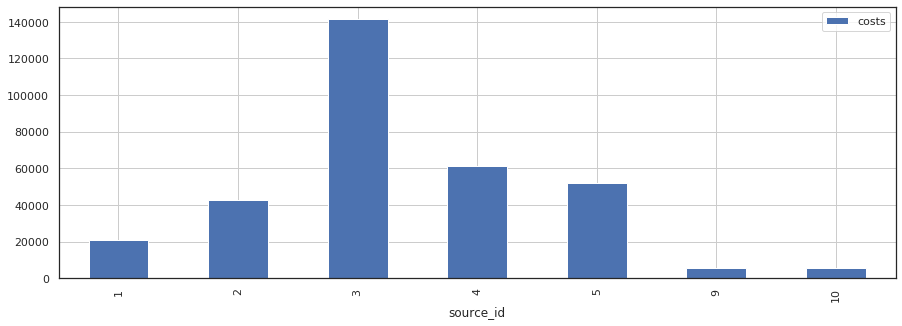

In [49]:
# Найдем сколько денег потратили в разрезе каждого источника
costs_source_id = costs.pivot_table(index='source_id', values='costs', aggfunc='sum')
costs_source_id.plot(kind='bar', grid=True, figsize=(15, 5))
costs_source_id

,costs
cost_month,
2017-12-01,38315.35
2017-11-01,37907.88
2017-10-01,36322.88
2018-01-01,33518.52
2018-02-01,32723.03
2018-03-01,30415.27
2017-09-01,24368.91
2018-04-01,22289.38
2018-05-01,22224.27


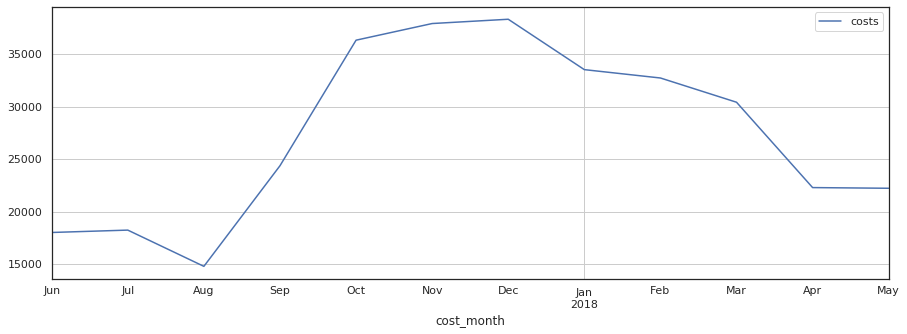

In [50]:
# Найдем сколько денег потратили на рекламу по времени
costs['cost_month'] = costs['date_costs'].astype('datetime64[M]')
costs_date_costs = costs.pivot_table(index='cost_month', values='costs', aggfunc='sum')
costs_date_costs.plot(grid=True, figsize=(15, 5))
costs_date_costs.sort_values(by='costs', ascending=False)

In [51]:
costs.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc='sum')

source_id,1,2,3,4,5,9,10
cost_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


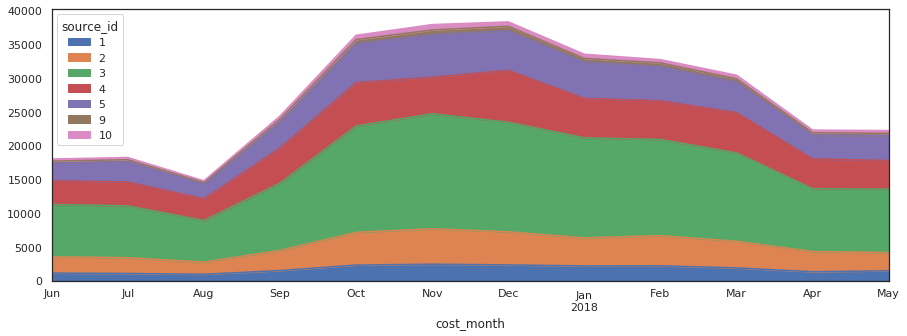

In [52]:
costs.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc='sum').plot.area(figsize=(15, 5))

### Промежуточные выводы

Всего на рекламу потратили 329131.62 у.е. В третий источник вкладывается наибольшее кол-во средств. Стремительный рост денежных вливаний в рекламу наблюдается с сентября по декабрь.

### Сколько денег приносят? (LTV)
### Сколько стоило привлечение одного покупателя из каждого источника? (CAC)
### На сколько окупились расходы? (ROI)

In [53]:
# Сформируем профили юзеров (acquisition - приобретение)
users = (visits.sort_values(by = ['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
               .rename(columns = {'start_ts' : 'acquisition_ts'})
        )
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')
costs['acquisition_date'] = costs['date_costs']
users = (users.reset_index()
              .set_index(['source_id', 'acquisition_date'])
              .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left')
        )
# Добавляем стоимость приобретения индивидуального пользователя
user_cost = (users.groupby(['source_id', 'acquisition_date'])
                  .agg({'device': 'count', 'costs': 'max'})
                  .rename(columns = {'device': 'users'})
            )

user_cost['acqusition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acqusition_cost']], how = 'left').reset_index()
users = users.set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                               'source_id', 'device', 'acqusition_cost']]
# Добавим метку о том платил ли пользователь или нет
users = users.join(orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns = {'buy_ts':'first_purchase_dt'}), how = 'left')
users['payer'] = ~users['first_purchase_dt'].isna()
users

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acqusition_cost,first_purchase_dt,payer
uid,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-09-11 00:06:00,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.600000,NaT,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-06-01 09:23:00,True
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-06-01 16:47:00,True
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.600000,NaT,False
...,...,...,...,...,...,...,...,...
17550479715346067160,2018-05-31 22:00:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,False
17715613363403416471,2018-05-31 03:30:00,2018-05-31,2018-05-01,10,desktop,0.177778,NaT,False
18076428844159112818,2018-05-31 17:47:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,False


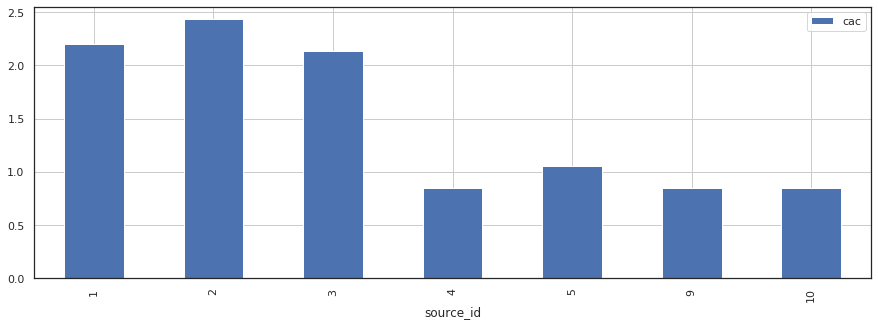

,cac
source_id,
1,2.200388
2,2.429952
3,2.137480
4,0.844188
5,1.051169
9,0.845909
10,0.843274


In [54]:
# Стоимость привлечения одного покупателя из каждого рекламного источника
user_cac = users.pivot_table(index='source_id', values='acqusition_cost').rename(columns={'acqusition_cost':'cac'})
user_cac.plot(kind='bar', grid=True, figsize=(15, 5))
plt.show()
user_cac

In [71]:
# Посчитаем когорты
cohorts = (users.groupby('acquisition_month')
                 .agg({'payer':'sum', 'acqusition_cost':'sum'})
                 .rename(columns = {'payer':'cohort_size'})
          )
# Расчитаем CAC
cohorts['cac'] = cohorts['acqusition_cost'] / cohorts['cohort_size']
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

# Расчитаем LTV
ltv = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'purchase_month', 'revenue']]
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv = ltv.groupby(['acquisition_month','age_month']).agg({'revenue':'sum'})
ltv = pd.pivot_table(ltv, index='acquisition_month', columns='age_month', values='revenue', aggfunc='sum')
ltv = ltv.cumsum(axis = 1) 
ltv = cohorts[['cohort_size']].join(ltv)
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = ['cohort_size']) 
ltv_cac = cohorts[['cohort_size', 'cac']].join(ltv.fillna(''))
ltv_cac

,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11
acquisition_month,,,,,,,,,,,,,,
2017-06-01,2923.0,6.163189,3.269754,4.181345,4.68244,6.01055,7.35869,8.32498,9.51894,10.2958,11.0888,12.2799,13.034,13.6935
2017-07-01,2458.0,7.416928,4.017449,4.448401,4.89954,5.29944,5.64403,5.96871,6.20793,6.52132,6.81608,7.05653,7.24659,
2017-08-01,1721.0,8.593359,3.622783,4.202284,4.78413,5.33393,5.80461,6.11425,6.39702,7.12116,7.60381,7.82212,,
2017-09-01,3058.0,7.966109,4.040942,5.251040,5.94124,9.35489,9.77623,10.4008,10.717,10.8777,11.0146,,,
2017-10-01,4678.0,7.764617,3.925250,4.739664,5.02334,5.24951,5.47257,5.69108,5.81483,5.95504,,,,
2017-11-01,4262.0,8.894388,3.878881,4.504779,4.81985,5.14119,5.40134,5.56737,5.73128,,,,,
2017-12-01,4074.0,9.402560,4.137703,4.564563,5.59507,6.85276,7.21054,7.64797,,,,,,
2018-01-01,3119.0,10.746560,3.397567,4.023312,4.39675,4.49482,4.66394,,,,,,,
2018-02-01,3186.0,10.266073,3.613506,4.236375,4.44453,4.72734,,,,,,,,


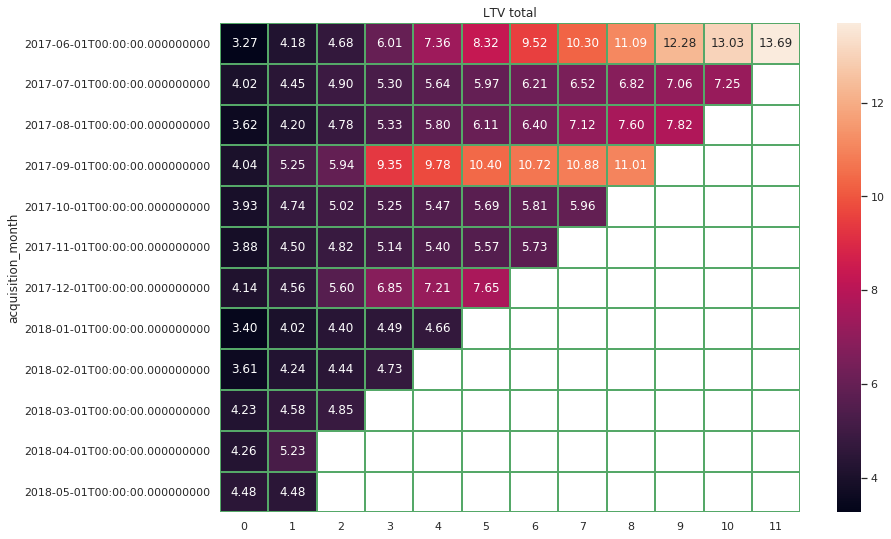

In [72]:
# Создадим тепловую карту LTV
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV total')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='g');

In [73]:
# Посчитаем ROI
roi = ltv.div(cohorts['cac'], axis = 0)
roi

,0,1,2,3,4,5,6,7,8,9,10,11
acquisition_month,,,,,,,,,,,,
2017-06-01,0.530530,0.678439,0.759742,0.975235,1.193974,1.350759,1.544483,1.670535,1.799200,1.992464,2.114807,2.221818
2017-07-01,0.541659,0.599763,0.660589,0.714506,0.760966,0.804742,0.836995,0.879248,0.918989,0.951409,0.977033,NaN
2017-08-01,0.421579,0.489015,0.556724,0.620704,0.675476,0.711509,0.744415,0.828681,0.884847,0.910252,NaN,NaN
2017-09-01,0.507267,0.659173,0.745815,1.174336,1.227228,1.305636,1.345325,1.365497,1.382679,NaN,NaN,NaN
2017-10-01,0.505530,0.610418,0.646952,0.676081,0.704809,0.732951,0.748889,0.766946,NaN,NaN,NaN,NaN
2017-11-01,0.436104,0.506474,0.541898,0.578026,0.607275,0.625942,0.644371,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.440061,0.485460,0.595059,0.728819,0.766869,0.813393,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.316154,0.374381,0.409131,0.418257,0.433994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.351985,0.412658,0.432934,0.460481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


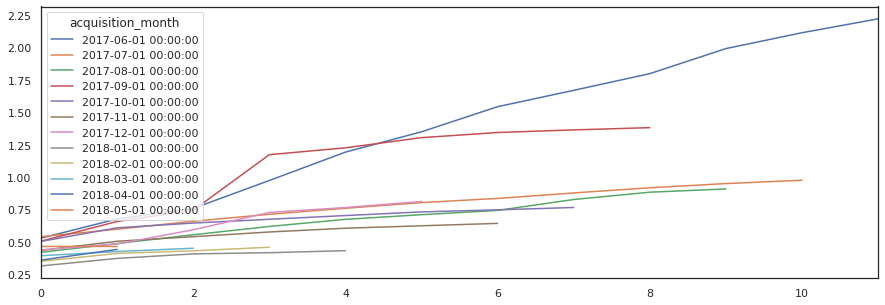

In [78]:
roi.T.plot(figsize=(15, 5))

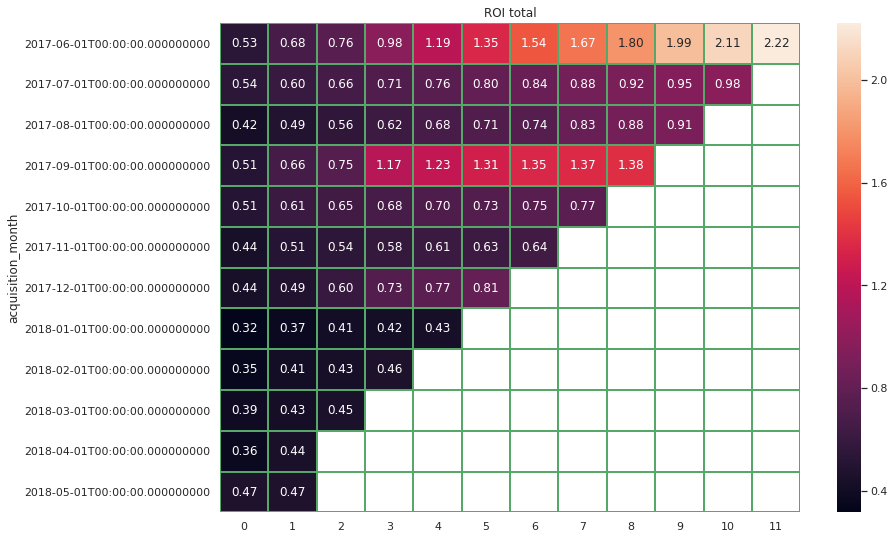

In [59]:
# Создадим тепловую карту ROI
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROI total')
sns.heatmap(roi, annot=True, fmt='.2f', linewidths=1, linecolor='g');

In [60]:
# Посчитаем когорты по рекламным источникам
cohorts = (users.groupby('source_id')
                 .agg({'payer':'sum', 'acqusition_cost':'sum'})
                 .rename(columns = {'payer':'cohort_size'})
          )
# Расчитаем CAC по рекламным источникам
cohorts['cac'] = cohorts['acqusition_cost'] / cohorts['cohort_size']
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

# Расчитаем LTV по рекламным источникам
ltv = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'purchase_month', 'revenue', 'source_id']]
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv = ltv.groupby(['source_id', 'age_month']).agg({'revenue':'sum'})
ltv = pd.pivot_table(ltv, index='source_id', columns='age_month', values='revenue', aggfunc='sum')
ltv = ltv.cumsum(axis = 1) 
ltv = cohorts[['cohort_size']].join(ltv)
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = ['cohort_size']) 
ltv_source_id = cohorts[['cohort_size', 'cac']].join(ltv[range(0, 7)].fillna(''))
ltv_source_id

,cohort_size,cac,0,1,2,3,4,5,6
source_id,,,,,,,,,
1,2899.0,7.186364,5.01103,5.91271,6.53207,7.47546,8.0591,8.44345,8.76577
2,3506.0,12.209367,5.10707,6.83526,8.55977,10.4129,11.3238,12.0295,12.3777
3,10473.0,13.493901,3.60076,4.16547,4.40178,4.61541,4.80527,4.93693,5.03932
4,10296.0,5.931779,3.63759,4.07046,4.27689,4.479,4.65029,4.85904,5.06111
5,6931.0,7.467378,4.15272,4.64651,4.93725,6.50599,6.75947,7.07028,7.23654
6,0.0,NaN,,,,,,,
7,1.0,0.000000,1.22,,,,,,
9,1088.0,5.013254,2.1825,2.76248,3.28825,3.75573,4.17557,4.38342,4.63808
10,1329.0,4.380075,2.67454,2.90242,2.9982,3.05593,3.18546,3.24597,3.29983


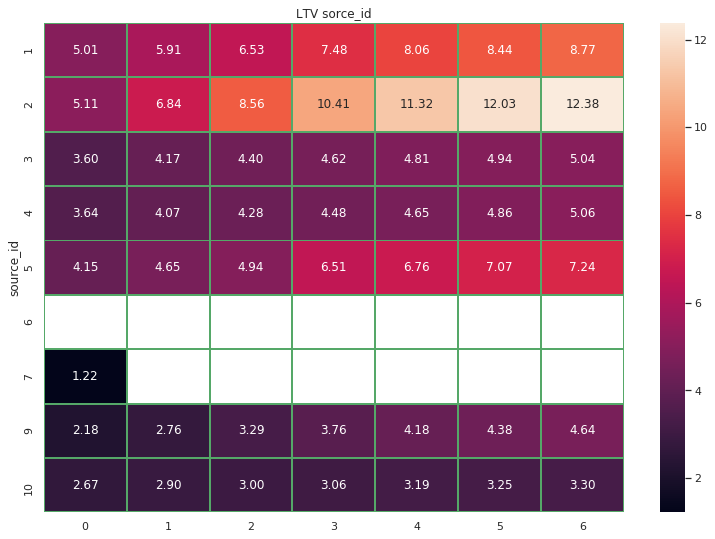

In [61]:
# Создадим тепловую карту LTV по рекламным источникам
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV sorce_id')
sns.heatmap(ltv[range(0, 7)], annot=True, fmt='.2f', linewidths=1, linecolor='g');

In [62]:
# Посчитаем ROI в разбивке по рекламным источникам
roi = ltv.div(cohorts['cac'], axis = 0)[range(0, 7)]
roi

,0,1,2,3,4,5,6
source_id,,,,,,,
1,0.697297,0.822769,0.908954,1.040228,1.121444,1.174927,1.219778
2,0.418291,0.559837,0.701083,0.852863,0.927469,0.985270,1.013786
3,0.266843,0.308693,0.326205,0.342036,0.356107,0.365864,0.373452
4,0.613237,0.686213,0.721014,0.755086,0.783961,0.819153,0.853220
5,0.556115,0.622242,0.661176,0.871255,0.905200,0.946823,0.969087
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,inf,NaN,NaN,NaN,NaN,NaN,NaN
9,0.435346,0.551036,0.655912,0.749159,0.832906,0.874366,0.925163
10,0.610616,0.662642,0.684509,0.697689,0.727260,0.741076,0.753372


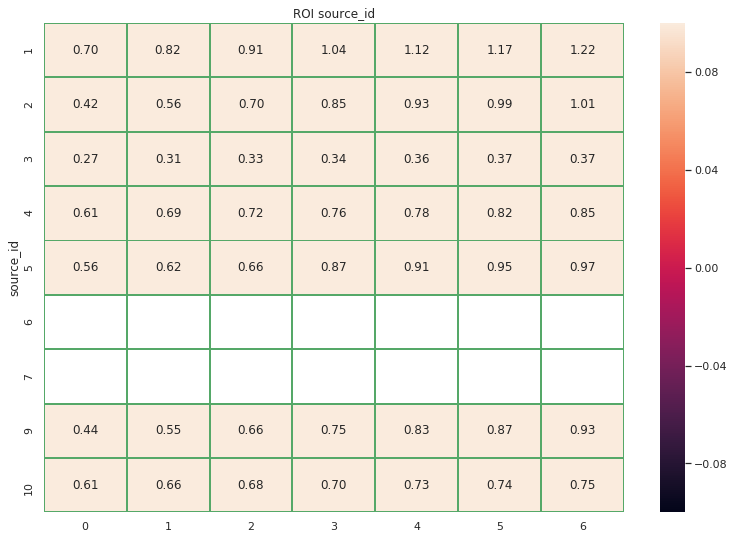

In [63]:
# Создадим тепловую карту ROI
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROI source_id')
sns.heatmap(roi, annot=True, fmt='.2f', linewidths=1, linecolor='g');

In [64]:
# Посчитаем когорты по устройствам
cohorts = (users.groupby('device')
                 .agg({'payer':'sum', 'acqusition_cost':'sum'})
                 .rename(columns = {'payer':'cohort_size'})
          )
# Расчитаем CAC по устройствам
cohorts['cac'] = cohorts['acqusition_cost'] / cohorts['cohort_size']
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

# Расчитаем LTV по устройствам
ltv = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'purchase_month', 'revenue', 'device']]
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
ltv = ltv.groupby(['device', 'age_month']).agg({'revenue':'sum'})
ltv = pd.pivot_table(ltv, index='device', columns='age_month', values='revenue', aggfunc='sum')
ltv = ltv.cumsum(axis = 1) 
ltv = cohorts[['cohort_size']].join(ltv)
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = ['cohort_size']) 
ltv_device = cohorts[['cohort_size', 'cac']].join(ltv[range(0, 7)].fillna(''))
ltv_device

,cohort_size,cac,0,1,2,3,4,5,6
device,,,,,,,,,
desktop,29211.0,8.047165,4.011006,4.642357,5.087798,5.888805,6.223169,6.510228,6.713893
touch,7312.0,12.855680,3.438590,4.116656,4.409964,4.630186,4.801991,4.965036,5.082611


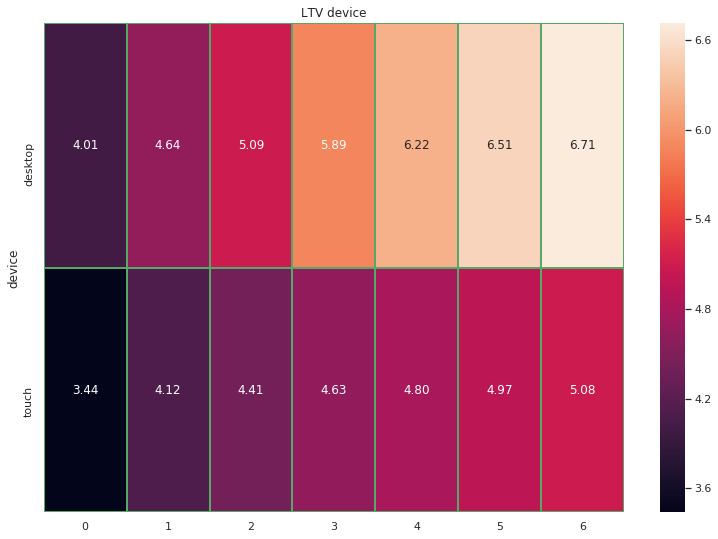

In [65]:
# Создадим тепловую карту LTV по устройствам
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV device')
sns.heatmap(ltv[range(0, 7)], annot=True, fmt='.2f', linewidths=1, linecolor='g');

In [66]:
# Посчитаем ROI в разбивке по устройствам
roi = ltv.div(cohorts['cac'], axis = 0)[range(0, 7)]
roi

,0,1,2,3,4,5,6
device,,,,,,,
desktop,0.498437,0.576893,0.632247,0.731786,0.773337,0.809009,0.834318
touch,0.267476,0.320221,0.343036,0.360167,0.373531,0.386213,0.395359


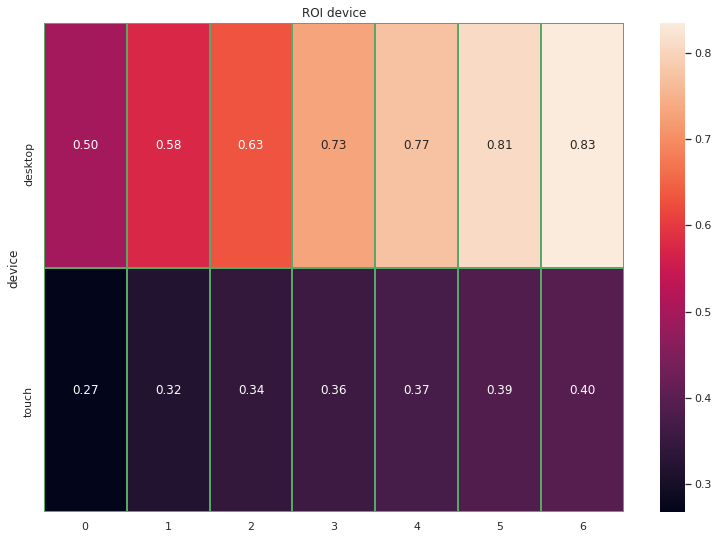

In [67]:
# Создадим тепловую карту ROI
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROI device')
sns.heatmap(roi, annot=True, fmt='.2f', linewidths=1, linecolor='g');

### Промежуточные выводы

Стоимость привлечения одного покупателя наиболее высокая у источников 1, 2 и 3.

LTV когорт пользователей, зарегистрировавшихся в июне, сентябре и декабре начинают отличаться по росту от остальных когорт уже с 3го месяца жизни. Правда, у декабрьской когорты рост с 6 месяца сильно затормозился. Соотвественно и окупаемости инвестиций (ROI) данные когорты достигают первыми и единственными, в наблюдаемом периоде (за исключением декабрьской): июньская на четвертый месяц, сентябрьская на третий.

При горизонте окупаемости в 6 месяцев, самый бурный рост LTV идет у рекламных источников 1 и 2. Окупаются в рассматриваемом периоде только источники 1 и 2.

LTV desktop устройств выше, чем у touch устройств. В рассматриваемом гиризонте окупаемости, ни один из источников не достигают ROI=1.

## Шаг 3. Выводы и рекомендации

Исходя из полученной информации можно сказать, что стоит инвестировать в источники 4 и 5, так как они приносят большУю долю пользователей, а также по ним большое кол-во сессий. Также в выбранном горизонте окупаемости их ROI близок к 1. Также я бы обратил внимание на источники 1 и 2, по кол-ву привлеченных покупателей они не в лидерах, но хорошо показывают себя по метрикам  пожизненной ценности (LTV) и сроках окупаемости(ROI). А вот вложения в источник 3 не совсем оправданы, так как судя по графику ROI, этот источник даже близко не окупает себя, а LTV существенно ниже, чем у других источников. В источник 3 вложено больше всего средств и по графику CAC он в лидерах, я бы рекомендовал перераспределить эти инвестиции в источники 1, 2, 4 и 5. 

Retention rate падает практически сразу на первом месяце жизни всех когор пользователей, поэтому возможно маркетингу стоит рассмотреть вариант предоставления бонусов за повторные покупки.

Повышение затрат на рекламу растет с осени и до Нового года, что вполне оправданно и подтверждается графиком роста покупок.

Кол-во заходов, покупок, средний чек и LTV больше у desktop - это более перспективная платформа.